## Imports

In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.float_format', '{:.5f}'.format)
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize
figsize(5, 5)

In [2]:
from sklearn.linear_model import LinearRegression

In [3]:
from utils import add_remaining_useful_life

In [4]:
from sklearn.metrics import mean_squared_error, r2_score
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

## Load Data

In [5]:
folder = 'data'
dataset = 'FD001'
index_cols = ['unit_number', 'time_cycle']
setting_cols = ['os_1', 'os_2', 'os_3']
sensor_cols = ['s_' + str(num) for num in range(1, 22)]
cols = index_cols + setting_cols + sensor_cols
train = pd.read_csv(os.path.join(folder, f'train_{dataset}.txt'), header=None, sep='\s+', names=cols)
train = add_remaining_useful_life(train)
X_test = pd.read_csv(os.path.join(folder, f'test_{dataset}.txt'), header=None, sep='\s+', names=cols)
y_test = pd.read_csv(os.path.join(folder, f'RUL_{dataset}.txt'), header=None, names=['RUL'])

## Data Setup

###  Configure Test set

In [6]:
test_max_cycles = X_test[index_cols].groupby('unit_number').max('time_cycle').reset_index().sort_values('unit_number')
test_max_cycles['RUL'] = y_test
test = pd.merge(X_test, test_max_cycles, on=['unit_number', 'time_cycle'], how='left')

### Scaling

In [7]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
train[train.columns[2:26]] = sc.fit_transform(train[train.columns[2:26]])
test[test.columns[2:26]] = sc.transform(test[test.columns[2:26]])

### Clipping training values

In [71]:
max_rul = 130
clip = True
if clip:
    train['RUL'] = train['RUL'].clip(upper=max_rul)

### Feature Selection

In [8]:
drop_by_corr = True
if drop_by_corr:
    corrs = train.corr()['RUL']
    cols_to_drop = list(corrs[(np.abs(corrs) < 0.01) |
          (pd.isnull(corrs))].index.values)
else:
    cols_to_drop = []
    
X_train = train.drop(cols_to_drop + index_cols + ['RUL'], axis=1)
y_train = train['RUL']

### Recurrent Structure

In [72]:
def create_dataset(X, y, lookback=1):
    dataX, dataY = [], []
    for i in range(len(X) - lookback):
        a = X[i: (i + lookback)]
        dataX.append(a)
        dataY.append(y[i + lookback])
    return np.array(dataX), np.array(dataY)

In [82]:
unit_train = []
for unit in train.unit_number.unique():
    unit_data = train[train.unit_number == unit].sort_values('time_cycle').reset_index(drop=True)
    unit_train.append(unit_data)

In [97]:
def augment_data(unit_data, lmbda):
    max_len = len(unit_data)
    temp = unit_train[0].diff()
    kink_point = temp[temp.RUL == -1].head(1).index.values[0]
    new_data = []
    for _ in range(lmbda):
        cutoff = np.random.randint(kink_point, max_len)
        data = unit_data.iloc[0: cutoff]
        new_data.append(data)
    return new_data

In [116]:
from functools import reduce
lmbda = 5
unit_train_aug = reduce(lambda x, y: x + y, [augment_data(unit_data, lmbda) for unit_data in unit_train])

In [118]:
lookback = 30
trainX, trainY = [], []
for data in unit_train_aug:
    unit_x = data.drop(index_cols + cols_to_drop + ['RUL'], axis=1).values
    unit_y = data['RUL'].values
    X, Y = create_dataset(unit_x, unit_y, lookback)
    trainX.append(X)
    trainY.append(Y)
    
trainX = np.concatenate(trainX)
trainY = np.concatenate(trainY)
print(trainX.shape)
print(trainY.shape)

(51206, 30, 15)
(51206,)


In [119]:
unit_test = []
for unit in test.unit_number.unique():
    unit_data = test[test.unit_number == unit].sort_values('time_cycle')
    unit_test.append(unit_data)

In [120]:
testX, testY = [], []
for data in unit_test:
    unit_x = data.drop(index_cols + cols_to_drop + ['RUL'], axis=1).values
    unit_y = data['RUL'].values
    X, Y = create_dataset(unit_x, unit_y, lookback)
    testX.append(X)
    testY.append(Y)
    
testX = np.concatenate(testX)
testY = np.concatenate(testY)
print(testX.shape)
print(testY.shape)

(10096, 30, 15)
(10096,)


In [121]:
testXlast = testX[~np.isnan(testY)]
testYlast = testY[~np.isnan(testY)]

## Model Setup

In [122]:
import tensorflow as tf
from tensorflow import keras

In [123]:
model = keras.Sequential()
#input
model.add(keras.layers.LSTM(units=50, return_sequences='true',
input_shape = (trainX.shape[1], trainX.shape[2])) )
model.add(keras.layers.Dropout(0.2))
#hidden layer 1
#model.add(keras.layers.LSTM(units=50, return_sequences='true'))
#model.add(keras.layers.Dropout(0.2))
#hidden layer 2
model.add(keras.layers.LSTM(units=50))
model.add(keras.layers.Dropout(0.2))
#output
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[keras.metrics.RootMeanSquaredError()])
print(model.summary())

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 30, 50)            13200     
_________________________________________________________________
dropout_13 (Dropout)         (None, 30, 50)            0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_14 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 51        
Total params: 33,451
Trainable params: 33,451
Non-trainable params: 0
_________________________________________________________________
None


In [61]:
model = keras.Sequential()
# Conv 1
model.add(keras.layers.Conv1D(filters=18, kernel_size=2, strides=1, padding='same',
    input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='same'))

# Conv 2
model.add(keras.layers.Conv1D(filters=36, kernel_size=2, strides=1, padding='same'))
model.add(keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='same'))

# Conv 3
model.add(keras.layers.Conv1D(filters=72, kernel_size=2, strides=1, padding='same'))
model.add(keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='same'))

# Flatten
shape = model.get_layer(index=-1).output_shape
model.add(keras.layers.Reshape([shape[1] * shape[2]]))

# Dense Layer
model.add(keras.layers.Dense(trainX.shape[1] * trainX.shape[2], activation='relu'))

# Reshape
model.add(keras.layers.Reshape([trainX.shape[1], trainX.shape[2]]))

# LSTM 1
model.add(keras.layers.LSTM(units=50, return_sequences=True))
model.add(keras.layers.Dropout(0.2))

# LSTM 2
model.add(keras.layers.LSTM(units=50))
model.add(keras.layers.Dropout(0.2))

# Output 
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[keras.metrics.RootMeanSquaredError()])
print(model.summary())

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_34 (Conv1D)           (None, 30, 18)            558       
_________________________________________________________________
max_pooling1d_34 (MaxPooling (None, 15, 18)            0         
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 15, 36)            1332      
_________________________________________________________________
max_pooling1d_35 (MaxPooling (None, 8, 36)             0         
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 8, 72)             5256      
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 4, 72)             0         
_________________________________________________________________
reshape_18 (Reshape)         (None, 288)             

In [124]:
history = model.fit(trainX, trainY, batch_size=32, epochs=15, validation_data=(testXlast, testYlast))

Train on 51206 samples, validate on 100 samples
Epoch 1/15
51206/51206 [==============================] - 18s 351us/sample - loss: 4964.9409 - root_mean_squared_error: 70.4623 - val_loss: 1728.2187 - val_root_mean_squared_error: 41.5718
Epoch 2/15
51206/51206 [==============================] - 13s 255us/sample - loss: 1269.2501 - root_mean_squared_error: 35.6265 - val_loss: 2399.7155 - val_root_mean_squared_error: 48.9869
Epoch 3/15
51206/51206 [==============================] - 13s 248us/sample - loss: 1029.4645 - root_mean_squared_error: 32.0853 - val_loss: 2553.6702 - val_root_mean_squared_error: 50.5339
Epoch 4/15
51206/51206 [==============================] - 13s 248us/sample - loss: 1026.7964 - root_mean_squared_error: 32.0437 - val_loss: 2550.8024 - val_root_mean_squared_error: 50.5055
Epoch 5/15
51206/51206 [==============================] - 13s 250us/sample - loss: 1029.2755 - root_mean_squared_error: 32.0823 - val_loss: 2560.1482 - val_root_mean_squared_error: 50.5979
Epoch 6

In [125]:
y_train_pred = model.predict(trainX)

In [126]:
evaluate(trainY, y_train_pred, label='train')
evaluate(testYlast, model.predict(testXlast), label='test')

train set RMSE:14.275353999973657, R2:0.7908714505233093
test set RMSE:15.832739645572484, R2:0.854838115926945


In [64]:
evaluate(trainY, y_train_pred, label='train')
evaluate(testYlast, model.predict(testXlast), label='test')

train set RMSE:12.420537829743934, R2:0.9178222526940844
test set RMSE:16.215651097524344, R2:0.8477317913775062


## Inspect Predictions

In [213]:
train_sub = train[train.time_cycle > lookback].copy()
train_sub['pred'] = y_train_pred

<AxesSubplot:xlabel='time_cycle'>

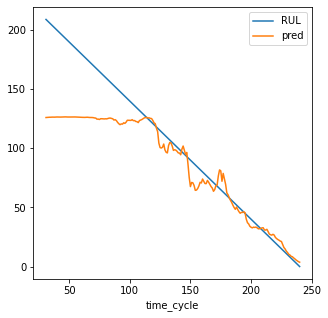

In [225]:
unit = 11
train_sub[train_sub.unit_number == unit].plot(x='time_cycle', y=['RUL', 'pred'], kind='line')